# Assignment 2 | FIT 5202 - Data processing for Big Data


Student: Cristiana Garcia Gewerc

ID: 3008887

## A. Creating Spark Session and Loading the Data

### Step 01: Import Spark Session and initialize Spark

In [1]:
# create entry points to spark
from pyspark import SparkContext, SparkConf # Spark
from pyspark.sql import SparkSession # Spark SQL

# We add this line to avoid an error : "Cannot run multiple SparkContexts at once". 
# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# If there is no existing spark context, we now create a new context
if (sc is None):
    # local[4]: run Spark locally with 4 working processors.
    sc = SparkContext(master="local[4]", appName="Assignment 2 FIT 5202")
spark = SparkSession(sparkContext=sc)

### Step 02: Load the dataset and print the schema and total number of entries

In [2]:
# loading the dataset
weather_df = spark.read.csv('weatherAUS.csv', header='true')

# display total number of lines
print("The dataset has %d lines" %weather_df.count())

The dataset has 142193 lines


In [3]:
# printSchema to analyse which are all the columns and what are their types
weather_df.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Location: string (nullable = true)
 |-- MinTemp: string (nullable = true)
 |-- MaxTemp: string (nullable = true)
 |-- Rainfall: string (nullable = true)
 |-- Evaporation: string (nullable = true)
 |-- Sunshine: string (nullable = true)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: string (nullable = true)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: string (nullable = true)
 |-- WindSpeed3pm: string (nullable = true)
 |-- Humidity9am: string (nullable = true)
 |-- Humidity3pm: string (nullable = true)
 |-- Pressure9am: string (nullable = true)
 |-- Pressure3pm: string (nullable = true)
 |-- Cloud9am: string (nullable = true)
 |-- Cloud3pm: string (nullable = true)
 |-- Temp9am: string (nullable = true)
 |-- Temp3pm: string (nullable = true)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



## B. Data Cleaning and Processing
Data cleaning and processing is an important aspect for any machine learning task. We have to carefully look into the data and based on the types, quality of the data, we have to plan our cleaning procedures.
### Step 03: Delete columns from the dataset
During the data cleaning and processing phase, we delete unnecessary data from the dataset to improve the efficiency and accuracy of our model. You have to think which columns are not contributing to the rain prediction. To keep things simple, you are required to delete the following columns due to data quality and accuracy. <br>
● Date <br>
● Location <br>
● Evaporation <br>
● Sunshine <br>
● Cloud9am <br>
● Cloud3pm <br>
● Temp9am <br>
● Temp3pm <br>
However, if you want to keep any of these columns, you can keep them if you process them in an intelligent way that improve the accuracy, that is fine, ​ however not mandatory​ .

In [4]:
# drop above listed columns
weather_df = weather_df.drop(*['Date', 'Location', 'Evaporation', 'Sunshine', 
                               'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm'])

### Step 04: Print the number of missing data in each column.
We already have an initial idea about the data structure from the schema. Even in
plain eyes, we can observe that there are lots of NA (null) values in the given dataset.
Your job in this step is to print the number of NA(null) values in each column.

In [5]:
from pyspark.sql.functions import count, when, isnan
# define function to count "NA"/NaN/NULL:
def count_na(column):
    weather_df.select(
    count(when(
        (weather_df[column]=='NA')|(weather_df[column].isNull()| (isnan(weather_df[column]))),
        weather_df[column]))
    .alias(column)).show()
# apply function to each column of our spark dataframe:
for column in weather_df.columns:
    count_na(column)

+-------+
|MinTemp|
+-------+
|    637|
+-------+

+-------+
|MaxTemp|
+-------+
|    322|
+-------+

+--------+
|Rainfall|
+--------+
|    1406|
+--------+

+-----------+
|WindGustDir|
+-----------+
|       9330|
+-----------+

+-------------+
|WindGustSpeed|
+-------------+
|         9270|
+-------------+

+----------+
|WindDir9am|
+----------+
|     10013|
+----------+

+----------+
|WindDir3pm|
+----------+
|      3778|
+----------+

+------------+
|WindSpeed9am|
+------------+
|        1348|
+------------+

+------------+
|WindSpeed3pm|
+------------+
|        2630|
+------------+

+-----------+
|Humidity9am|
+-----------+
|       1774|
+-----------+

+-----------+
|Humidity3pm|
+-----------+
|       3610|
+-----------+

+-----------+
|Pressure9am|
+-----------+
|      14014|
+-----------+

+-----------+
|Pressure3pm|
+-----------+
|      13981|
+-----------+

+---------+
|RainToday|
+---------+
|     1406|
+---------+

+------------+
|RainTomorrow|
+------------+
|           0|
+

### Step 05: Fill the missing data with average value and maximum occurrence value.
In this step you have to fill in all the missing data with average value (for numeric column) or maximum frequency value (for non-numeric column).

1) Firstly, identify the columns which have numeric values (e.g., MinTemp, MaxTemp), calculate the average and fill the null value with the average.

In [6]:
weather_df.take(1)

[Row(MinTemp='13.4', MaxTemp='22.9', Rainfall='0.6', WindGustDir='W', WindGustSpeed='44', WindDir9am='W', WindDir3pm='WNW', WindSpeed9am='20', WindSpeed3pm='24', Humidity9am='71', Humidity3pm='22', Pressure9am='1007.7', Pressure3pm='1007.1', RainToday='No', RainTomorrow='No')]

<font color=blue><b> Now that we can see which are the numeric columns ('MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Pressure9am', 'Pressure3pm') we will calculate their averages:</font></b> 

In [7]:
num_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 
            'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 
            'Humidity3pm','Pressure9am', 'Pressure3pm']
# collecting the means of the "num_cols"
num_mean = weather_df.select(num_cols).describe().collect()[1]
# printing the means with help of dictinary format
for item in num_mean.asDict().items():
    print(item)

('summary', 'mean')
('MinTemp', '12.186399728729098')
('MaxTemp', '23.226784191272444')
('Rainfall', '2.3499740743111954')
('WindGustSpeed', '39.98429165757619')
('WindSpeed9am', '14.001988000994')
('WindSpeed3pm', '18.63757586179718')
('Humidity9am', '68.8438103105705')
('Humidity3pm', '51.482606091656265')
('Pressure9am', '1017.6537584159781')
('Pressure3pm', '1015.258203537907')


<font color=red><b>Answer:</font></b> <font color=blue><b>
The columns which have numerical values and their respective averages are:<br>
    . MinTemp: 12.19 <br>
    . MaxTemp: 23.23<br>
    . Rainfall: 2.34<br>
    . WindGustSpeed: 39.98<br>
    . WindSpeed9am: 14.00<br>
    . WindSpeed3pm: 18.64<br>
    . Humidity9am: 68.84<br>
    . Humidity3pm: 51.48<br>
    . Pressure9am: 1017.65<br>
    . Pressure3pm: 1015.26<br>
Now, we are going to replace their "NA" entries with the average values.
</font></b> 


In [8]:
i=1
for col in num_cols: # for each numeric column, impute the corresponding mean in case its "NA", NULL or NaN
    weather_df = weather_df.withColumn(col,
              when(
                  (weather_df[col]=='NA')|(weather_df[col].isNull()| (isnan(weather_df[col])))
                  , num_mean[i]).otherwise(weather_df[col]))
    i+=1

2) Secondly, identify the columns with non-numeric values (e.g., WindGustDir, WindDir9am)
and find the most frequent item (e.g., wind direction). 

<font color=blue><b>All other columns present non-numeric values, i.e. 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow'. Let's find their most fequent item:</font></b> 


In [9]:
from pyspark.sql.functions import desc

nom_num_cols = ['WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday', 'RainTomorrow']
# collecting the most frequent of values of the "non_num_cols"
nom_num_modes =[]
for col in nom_num_cols:
    nom_num_modes.append(weather_df.groupBy(col).count().sort(desc("count")).collect()[0])
# printing the modes
print(nom_num_modes)   

[Row(WindGustDir='W', count=9780), Row(WindDir9am='N', count=11393), Row(WindDir3pm='SE', count=10663), Row(RainToday='No', count=109332), Row(RainTomorrow='No', count=110316)]


<font color=red><b>Answer:</font></b> <font color=blue><b>
The columns which have non-numerical values and their respective averages are:<br>
    . WindGustDir: 'W'<br>
    . WindDir9am: 'N'<br>
    . WindDir3pm: 'SE'<br>
    . RainToday: 'No'<br>
    . RainTomorrow: 'No'<br>
Now, we are going to replace their "NA" entries with their max occurence values.
</font></b> 


3) Now fill the null values with that item for that particular column.

In [10]:
i=0
for col in nom_num_cols:
    # nom_num_modes is a list of one element per non numeric col. FOr each one of them, the first [0] element is
    # the mode of the corresponding column
    weather_df = weather_df.withColumn(col,
              when((weather_df[col]=='NA')|(weather_df[col].isNull()| (isnan(weather_df[col]))),
                   nom_num_modes[i][0]).otherwise(weather_df[col]))
    i+=1

### Step 06: Data transformation
In this step, you need to transform the data so that it will be useful to process by the machine learning algorithm. Before transforming your non-numerical data, do the type casting (to double) of the numerical value columns as they are defined as “String” (see, the schema of the dataset). For the non-numerical value column (i.e., WindGustDir, WindDir9am, WindDir3pm, RainTomorrow) use the StringIndexer method to convert them into numbers

In [11]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

# numerical data
for col in num_cols:
    weather_df = weather_df.withColumn(col, weather_df[col].cast('double'))

# non-numerical
cat_indexers = [StringIndexer(inputCol=col, outputCol=col+"_index").fit(weather_df) for col in nom_num_cols]
ml_pipeline = Pipeline(stages=cat_indexers)
weather_df = ml_pipeline.fit(weather_df).transform(weather_df).drop(*nom_num_cols)

# checking new schema
weather_df.printSchema()

root
 |-- MinTemp: double (nullable = true)
 |-- MaxTemp: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- WindGustSpeed: double (nullable = true)
 |-- WindSpeed9am: double (nullable = true)
 |-- WindSpeed3pm: double (nullable = true)
 |-- Humidity9am: double (nullable = true)
 |-- Humidity3pm: double (nullable = true)
 |-- Pressure9am: double (nullable = true)
 |-- Pressure3pm: double (nullable = true)
 |-- WindGustDir_index: double (nullable = false)
 |-- WindDir9am_index: double (nullable = false)
 |-- WindDir3pm_index: double (nullable = false)
 |-- RainToday_index: double (nullable = false)
 |-- RainTomorrow_index: double (nullable = false)



### Step 07: Create the feature vector and divide the dataset
In this step, you have to create the feature vector from the given columns. When you create you feature vector, remember to exclude the column that you will be using for testing the accuracy of your model.

In [12]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

#feature_cols = list(set(weather_df.columns) - {'RainTomorrow_index'})

feature_cols = ['MinTemp','MaxTemp','Rainfall', 'WindGustSpeed', 'WindSpeed9am','WindSpeed3pm', 'Humidity9am',
                'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                'WindGustDir_index','WindDir9am_index', 'WindDir3pm_index', 'RainToday_index']



# creating the feature vector
vector_assembler = VectorAssembler(inputCols= feature_cols, outputCol="features")

df_temp = vector_assembler.transform(weather_df)
print(df_temp.take(1))

weather_df = df_temp['RainTomorrow_index', 'features']
print("\nOnly label and features: \n", weather_df.take(1))

[Row(MinTemp=13.4, MaxTemp=22.9, Rainfall=0.6, WindGustSpeed=44.0, WindSpeed9am=20.0, WindSpeed3pm=24.0, Humidity9am=71.0, Humidity3pm=22.0, Pressure9am=1007.7, Pressure3pm=1007.1, WindGustDir_index=0.0, WindDir9am_index=6.0, WindDir3pm_index=7.0, RainToday_index=0.0, RainTomorrow_index=0.0, features=DenseVector([13.4, 22.9, 0.6, 44.0, 20.0, 24.0, 71.0, 22.0, 1007.7, 1007.1, 0.0, 6.0, 7.0, 0.0]))]

Only label and features: 
 [Row(RainTomorrow_index=0.0, features=DenseVector([13.4, 22.9, 0.6, 44.0, 20.0, 24.0, 71.0, 22.0, 1007.7, 1007.1, 0.0, 6.0, 7.0, 0.0]))]


After creation of your feature vector, you have to split your dataset into two (e.g., training and testing). In this assignment, you have to spit the dataset randomly and between 70 percent and 30 percent.

In [21]:
# Splitting the dataset between training and test dataset (setting seed to have reproducible results):
(training_data, test_data) = weather_df.randomSplit([0.7, 0.3], seed = 100)

## C. Apply Machine Learning Algorithms
### Step 08: Apply machine learning classification algorithms on the dataset and compare their accuracy. Plot the accuracy as bar graph.
You have to use DecisionTreeClassifier(), RandomForestClassifier(), and LogisticRegression(), GBTClassifier() methods in spark to calculate the probability of the rain fall tomorrow based on the other related data points (e.g., temperature, wind, humidity).

1. Run and calculate the accuracy of decision tree algorithm

In [22]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# create, fit and predict the model
dt = DecisionTreeClassifier(labelCol="RainTomorrow_index", featuresCol="features", seed = 1234)
dt_model = dt.fit(training_data)
dt_predictions = dt_model.transform(test_data)
dt_predictions.select("prediction", "RainTomorrow_index").show(5)

## accuracy evaluator for all models ##
evaluator = MulticlassClassificationEvaluator(\
labelCol="RainTomorrow_index", predictionCol="prediction",\
metricName="accuracy")

# testing decision tree accuracy
dt_accuracy = evaluator.evaluate(dt_predictions)
print("Test Error = %g " % (1.0 - dt_accuracy))

+----------+------------------+
|prediction|RainTomorrow_index|
+----------+------------------+
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
+----------+------------------+
only showing top 5 rows

Test Error = 0.165842 


2. Run and calculate the accuracy of random forest algorithm

In [23]:
from pyspark.ml.classification import RandomForestClassifier

# create, fit and predict the model
rf = RandomForestClassifier(labelCol="RainTomorrow_index", featuresCol="features", numTrees=10, seed=1234)
rf_model = rf.fit(training_data)
rf_predictions = rf_model.transform(test_data)
rf_predictions.select("prediction", "RainTomorrow_index").show(5)

# testing random forest accuracy
rf_accuracy = evaluator.evaluate(rf_predictions)
print("Test Error = %g" % (1.0 - rf_accuracy))

+----------+------------------+
|prediction|RainTomorrow_index|
+----------+------------------+
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
+----------+------------------+
only showing top 5 rows

Test Error = 0.165372


3. Run and calculate the accuracy of logistic regression

In [24]:
from pyspark.ml.classification import LogisticRegression

# create, fit and predict the model
lr = LogisticRegression(featuresCol = 'features', labelCol = 'RainTomorrow_index', maxIter=10)
lr_model = lr.fit(training_data)
lr_predictions = lr_model.transform(test_data)
lr_predictions.select("prediction", "RainTomorrow_index").show(5)

# testing logistic regression accuracy
lr_accuracy = evaluator.evaluate(lr_predictions)
print("Test Error = %g" % (1.0 - lr_accuracy))

+----------+------------------+
|prediction|RainTomorrow_index|
+----------+------------------+
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
+----------+------------------+
only showing top 5 rows

Test Error = 0.18534


4. Run and calculate the accuracy of gradient boosted trees classifier

In [25]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(featuresCol = 'features', labelCol = 'RainTomorrow_index', maxIter=10, seed=1234)
gbt_model = gbt.fit(training_data)
gbt_predictions = gbt_model.transform(test_data)
gbt_predictions.select("prediction", "RainTomorrow_index").show(5)

# testing gradient boosted trees accuracy
gbt_accuracy = evaluator.evaluate(gbt_predictions)
print("Test Error = %g" % (1.0 - gbt_accuracy))

+----------+------------------+
|prediction|RainTomorrow_index|
+----------+------------------+
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
|       0.0|               0.0|
+----------+------------------+
only showing top 5 rows

Test Error = 0.160328


Finally, you have to draw the graph (e.g. bar chart) to demonstrate the comparison of their accuracy.

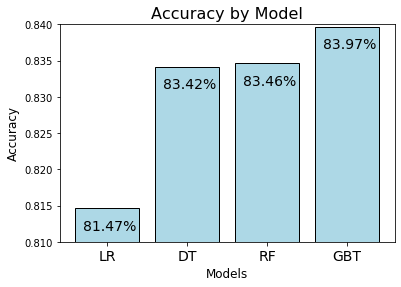

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

# preparing data for the plot
accuracy_compare = [lr_accuracy, dt_accuracy, rf_accuracy, gbt_accuracy]
legend = ['LR', 'DT', 'RF', 'GBT']

# plotting
bars = plt.bar(legend, accuracy_compare, align='center', color='lightblue', edgecolor='black')
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Accuracy by Model', fontsize=16)
plt.xticks(size=14)
plt.ylim(0.81, 0.84)
# text on the top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(x = bar.get_x() + 0.1, y = yval - 0.003, s = str(round(yval*100,2))+'%', size =14)
plt.show()

<font color=red><b>Answer:</font></b> <font color=blue><b>
The worst model in terms of accuracy was logistic regression, followed by random forest, decision tree and gradient boosted trees, which was the best one. All the accuracies were found within a range of 81%-84%. The tree-based models presented a very similar accuracy metric. 
</font></b> 

### Step 09: Calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm. Explain how the accuracy of the predication can be improved?
Finding the accuracy of the model does not always represent the quality of the model for a given dataset. Number of false positive and false negative identification also plays an important role when we decide about any particular classification model. The way we can calculate is called confusion matrix. You can use confusionMatrix() method to calculate the confusion matrix. From the confusion matrix show the precision, recall and f1 score of each classification model.

In [27]:
from pyspark.mllib.evaluation import MulticlassMetrics
# defining a function to take as argument the spark dataframe that contains the true values and predictions and 
# calculate the confusion matrix based on that:
def confusion_matrix(spark_df):
    # the MulticlassMetrics() functions takes as input an RDD of (prediction, label) pairs.
    # We need to transform our dataframes of predictions to this shape:
    rdd = spark_df.select(['prediction', 'RainTomorrow_index']).rdd.map(tuple)
    # Using confusion matrix method from multiclass to return ou confusion matrix (as array) 
    metrics = MulticlassMetrics(rdd)
    return metrics.confusionMatrix().toArray()

# From the confusion matrix show the precision, recall and f1 score of each classification model:
# Precision is the number of true positives divided by the number of true positives plus the number of false positives
# recall is the number of true positives divided by the number of true positives plus the number of false negatives
# F1 score is the harmonic mean of precision and recall 
models = ['LR', 'DT', 'RF', 'GBT']
i=0
for df in [lr_predictions, dt_predictions, rf_predictions, gbt_predictions]:
    print(models[i],':\n')
    cm = confusion_matrix(df)
    precision = cm[1,1]/(cm[0,1]+cm[1,1])
    recall = cm[1,1]/(cm[1,1]+cm[1,0])
    f1 = 2*precision*recall/(precision+recall)
    print('Precision: ', precision, '\nRecall: ', recall, '\nF1 Score: ', f1, '\n')
    i+=1

LR :

Precision:  0.6339212131201583 
Recall:  0.4038219235615288 
F1 Score:  0.493361554743121 

DT :

Precision:  0.7310007524454477 
Recall:  0.40802183956320875 
F1 Score:  0.5237196765498652 

RF :

Precision:  0.7681975736568457 
Recall:  0.372322553548929 
F1 Score:  0.5015558698727015 

GBT :

Precision:  0.73477578084104 
Recall:  0.44214615707685845 
F1 Score:  0.5520812848246476 



Explain how you can improve the accuracy of the prediction. <br>
<font color=red><b>Answer:</font></b> <font color=blue><b>
We could improve the Accuracy of them by introducing Cloud9am, Cloud3pm and Sunshine as features. If we are predicting rain tomorrow, it is logical that the fraction of sky obscured by cloud today and the number of hours of bright sunshine are correlated with the rain occurence in the next day, and helpful for our model. Other variables that were considered should be also analysed, maximum and minimum temperature, for instace, might not be so important for our model and maybe could  be eliminated from the analysis.

Still on the feature engineering side, we can rescale the variables so that  the variables with higher scales such as pressure do not bias the model. We could also improve our analysis by using cross-validation to test the model's ability to predict new data, in order to flag problems like overfitting or selection bias.

Furthermore, I can also improve the models by searching for the best hyper-parameters. For instance, for the 3 tree-based models, we could play with the parameter 'maxDepth',  having in mind that deeper trees are more expressive (potentially allowing higher accuracy), but they are also more costly to train and are more likely to overfit. For the ensemble models (GBT and Random Forest), the parameter 'numTrees'/'numInteractions' can be changed. By increasing the number of trees, the variance in predictions will decrease, improving the model’s test-time accuracy. It is important to mention that training time increases almost linearly as the number of trees increases. For the Logistic Regression, we can increase the number of interations with the parameter 'maxIter' to make the model understand the data patterns better, and so, improve its accuracy. (Apache Spark Documentation, 2019).
 
</font></b> 

## References:

Apache Spark Documentation, 2019, https://spark.apache.org/docs/2.3.0/ml-classification-regression.html <br>
Apache Spark Documentation, 2019, https://spark.apache.org/docs/2.3.0/mllib-ensembles.html#gradient-boosted-trees-gbts
